# Productivity Group
OOI Data Labs Workshop - July 2019

Revised Nov 1, 2019

**Working Title**: Factors affecting Primary Production.

**Short Description**: 
Explore the effect of abiotic factors, such as nutrient concentration, light availability, and temperature, on primary productivity.

In [0]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import dask
! pip install netcdf4==1.5.0
import matplotlib.pyplot as plt
import numpy as np

# Setup default plot styles
import seaborn as sns
sns.set()

## 1. Request Data from OOINet

* **Instruments:** All Telemetered
  * GS01SUMO-RID16-02-FLORTD000 (Chl a (ug L-1) from 3-Wavelength Fluorometer)
  * GS01SUMO-RID16-07-NUTNRB000 Dissolved Nitrate Concentration (uMol L-1)
  * GS01SUMO-RID16-08-SPKIRB000 Spectral Irradiance (uW cm-2 nm-1)
  * GS01SUMO-RID16-03-CTDBPF000 CTD - Temperature (degrees C) 
* **Time range:** 
  * Concept Invention: 2018-12-04 00:00:00 to present
  * Application: 2015-12-14 to present for FLORT and SPIKR, 2018-12-04 for NUTNR


In [0]:
def request_data(reference_designator,method,stream,start_date=None,end_date=None):
  site = reference_designator[:8]
  node = reference_designator[9:14]
  instrument = reference_designator[15:]
  
  # Create the request URL
  api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
  data_request_url ='/'.join((api_base_url,site,node,instrument,method,stream))

  # All of the following are optional, but you should specify a date range
  params = {
    'format':'application/netcdf',
    'include_provenance':'true',
    'include_annotations':'true'
  }
  if (start_date):
    params['beginDT'] = start_date
  if (end_date):
    params['endDT'] = end_date

  # Make the data request
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  
  # Return just the THREDDS URL
  return data['allURLs'][0] 

In [0]:
API_USERNAME = ''
API_TOKEN = ''

In [0]:
# Data Requests
# request_data('GS01SUMO-RID16-03-CTDBPF000','telemetered','ctdbp_cdef_dcl_instrument',
#              '2015-12-14T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('GS01SUMO-RID16-02-FLORTD000','telemetered','flort_sample',
#              '2015-12-14T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('GS01SUMO-RID16-07-NUTNRB000','telemetered','nutnr_b_dcl_full_instrument',
#              '2015-12-14T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('GS01SUMO-RID16-07-NUTNRB000','telemetered','suna_dcl_recovered',
#              '2015-12-14T00:00:00.000Z','2019-11-01T00:00:00.000Z')
# request_data('GS01SUMO-RID16-08-SPKIRB000','telemetered','spkir_abj_dcl_instrument',
#              '2015-12-14T00:00:00.000Z','2019-11-01T00:00:00.000Z')


## 2. Load Data Files
* It turns out, we don't need to load the CTD file, because temp and salinity are included in the FLORT and NUTNR datasets, so we'll just load those.  
* Also, because of the size and complexity of the SPKIR dataset, we will load that separately (see the next section).
* In addition, the NUTNR instrument switched instrument types over this timeframe, so we have to merge two streams to get a more complete dataset (though, for the purposes of the activity, it appears only the 2nd half is needed).

In [0]:
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191025T203757327Z-GS01SUMO-RID16-03-CTDBPF000-telemetered-ctdbp_cdef_dcl_instrument/catalog.html'
url_flort = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191025T203811494Z-GS01SUMO-RID16-02-FLORTD000-telemetered-flort_sample/catalog.html'
url_nutnr = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191025T203824405Z-GS01SUMO-RID16-07-NUTNRB000-telemetered-nutnr_b_dcl_full_instrument/catalog.html'
url_nutnr2 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191101T174459296Z-GS01SUMO-RID16-07-NUTNRB000-telemetered-suna_dcl_recovered/catalog.html'
url_spkir = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20191025T203834177Z-GS01SUMO-RID16-08-SPKIRB000-telemetered-spkir_abj_dcl_instrument/catalog.html'

In [0]:
def get_data(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
#   print(selected_datasets)
  selected_datasets = sorted(selected_datasets)
  
  # Load in dataset
  ds = xr.open_mfdataset(selected_datasets)
  ds = ds.swap_dims({'obs': 'time'}) # Swap the primary dimension
  ds = ds.chunk({'time': 1000}) # Used for optimization
  ds = ds.sortby('time') # Data from different deployments can overlap so we want to sort all data by time stamp.
  return ds

In [0]:
%%time
# Load the datasets 
# data_ctd = get_data(url_ctd)
data_flort = get_data(url_flort,'ctdbp')
data_nutnr = get_data(url_nutnr,'ctdbp')
data_nutnr2 = get_data(url_nutnr2,'ctdbp')

/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 16 times more chunks
  return self.array[key]
/usr/local/lib/python3.6/dist-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


CPU times: user 1min 35s, sys: 9.45 s, total: 1min 45s
Wall time: 2min 21s


In [0]:
%%time 
# Subset and resample
avgint = '1D'
# data_ctd = data_ctd[['temp','practical_salinity','pressure']].load().resample(time=avgint).mean()
data_flort = data_flort[['fluorometric_chlorophyll_a','temp','practical_salinity']].load().resample(time=avgint).mean()
data_nutnr = data_nutnr[['salinity_corrected_nitrate','temp','practical_salinity','nitrate_concentration']].load().resample(time=avgint).mean()
data_nutnr2 = data_nutnr2[['salinity_corrected_nitrate','temp','practical_salinity','nitrate_concentration']].load().resample(time=avgint).mean()

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 5min 49s, sys: 1min 13s, total: 7min 2s
Wall time: 6min 16s


In [0]:
# Remove low nitrate values
data_nutnr['salinity_corrected_nitrate'] = data_nutnr['salinity_corrected_nitrate'].where(data_nutnr['salinity_corrected_nitrate'] <100)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


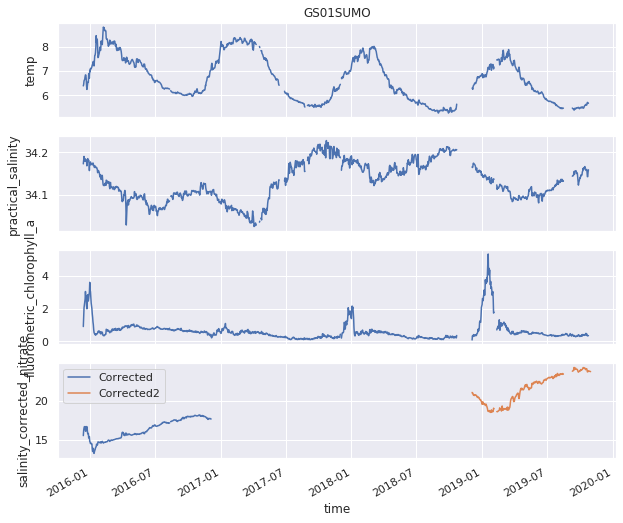

In [0]:
# Let's plot what we have so far
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,sharex=True,figsize=(10,8))

data_flort.temp.plot(ax=ax1)
data_flort.practical_salinity.plot(ax=ax2)
data_flort.fluorometric_chlorophyll_a.plot(ax=ax3)
data_nutnr.salinity_corrected_nitrate.plot(ax=ax4,label='Corrected')
data_nutnr2.salinity_corrected_nitrate.plot(ax=ax4,label='Corrected2')
# data_nutnr.nitrate_concentration.plot(ax=ax4,label='Raw')
# data_nutnr2.nitrate_concentration.plot(ax=ax4,label='Raw')
ax4.legend()

ax1.set_xlabel('');
ax2.set_xlabel('');
ax3.set_xlabel('');
# ax4.set_ylim(12,26)
ax1.set_title('GS01SUMO');

fig.savefig('GS01SUMO_productivity_quick.png')

## Process SPKIR
* Due to the size of this dataset, we need to process the files individually.  
* In addition, let's try to subset out the daylight hours in order to get an estimate of how much light there is during the day, rather than averaging over the full day.

In [0]:
def get_datafiles(url,bad_inst=''):
  '''Function to grab all data from specified directory'''
  tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
  datasets = requests.get(url).text
  urls = re.findall(r'href=[\'"]?([^\'" >]+)', datasets)
  x = re.findall(r'(ooi/.*?.nc)', datasets)
  for i in x:
    if i.endswith('.nc') == False:
      x.remove(i)
  for i in x:
    try:
      float(i[-4])
    except:
      x.remove(i)
  datasets = [os.path.join(tds_url, i) for i in x]
  
  # Remove extraneous files if necessary
  selected_datasets = []
  for d in datasets:
    if (bad_inst) and bad_inst in d:
      pass
    elif 'ENG000' in d: #Remove engineering streams for gliders
      pass
    else:
      selected_datasets.append(d)
  return sorted(selected_datasets)

In [0]:
# List of SPKIR files
spikr_files = get_datafiles(url_spkir)

In [0]:
# Let's open one to start
data = xr.open_dataset(spikr_files[1])
data = data.swap_dims({'obs':'time'})

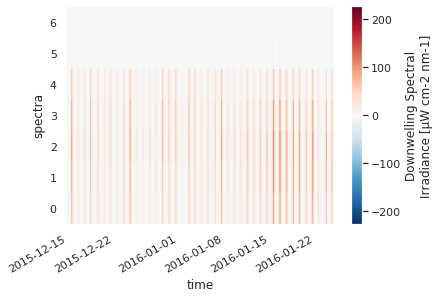

In [0]:
# Quickplot
data.spkir_abj_cspp_downwelling_vector.plot(x='time');

In [0]:
import textwrap
textwrap.wrap(data.spkir_abj_cspp_downwelling_vector.comment)

['Downwelling Spectral Irradiance is the measure of electromagnetic',
 'radiation per unit area received (i.e. incident) by a sensor within',
 'the seawater column. Downwelling spectral irradiance is calculated',
 'from measurements made across 7 specific, pre-defined wavebands as',
 'follows: 1 = 412nm, 2 = 443nm, 3 = 490nm, 4 = 510nm, 5 = 555nm, 6 =',
 '620nm, 7 = 683nm..']

As we can see from this graph, the data includes measurements from 7 spectral bands, and has a strong diurnal cycle.  For the purposes of this Data Exploration, what we really want is a general measurement of the amount of light available on a given day.  

So, subsetting a single band is really all we need.  But it's not clear which one might be best.

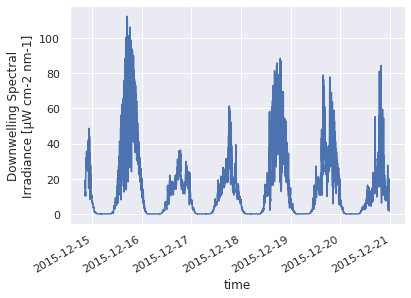

In [0]:
# Subset the data and plot
data_sub = data.spkir_abj_cspp_downwelling_vector.sel(time=slice('2015-12-14', '2015-12-20'), spectra=3)
data_sub.plot();

This still isn't ideal, if what we're really interested in s daily average.  We could crudely take a daily average, but that would be biased by the zero values measured during the night.  

Alternatively, we could subset out a specific hour, but given the variability that occurs during a day (e.g. clouds passing through) we might also bias the data that way.  

The best approach is probably to average over the daylight hours, but how do we do that?

### Option 1 - Crude estimate of daylight hours'
One might assume we could just take the noon hour, or a range of hours around that, but because the data is in UTC, we don't actually know what local noon is.  But, if we average over day-hour, we can easily figure that out.

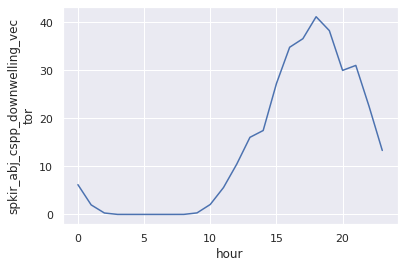

In [0]:
data_sub.groupby('time.hour').mean().plot();

Using the approach, it looks like the peak is around 1800, so we could simply take a 6-hour window around that for our average.

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


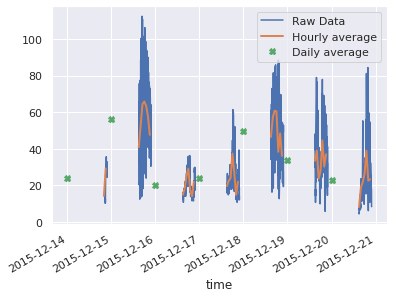

In [0]:
data_op1 = data_sub.where(data_sub.time.dt.hour>=15).where(data_sub.time.dt.hour<=21)
data_op1.plot(label='Raw Data')
data_op1.resample({'time':'H'}).mean().plot(label='Hourly average',linewidth=2)
data_op1.resample({'time':'D'}).mean().plot(label='Daily average',marker='X',linestyle='')
plt.legend();

### Option 2 - Sun angle
Alternatively, we could find out what the sun angle is for the given location and time, and only average data points when the sun is sufficiently above the horizon.  This also takes into account seasonal affects, i.e. more sunlight hours in the summer.

In [0]:
!pip install pysolar
import pysolar.solar as solar
import pandas as pd

In [0]:
# Calculate solar angle
data_solar = solar.get_altitude_fast(data.geospatial_lat_min, data.geospatial_lon_min, data_sub.time.values)

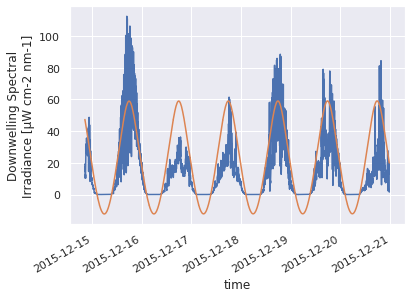

In [0]:
data_sub.plot()
plt.plot(data_sub.time,data_solar);

Remember, this is the southern hemisphere, so December is actually summer, and these are the highest angles reached all year.

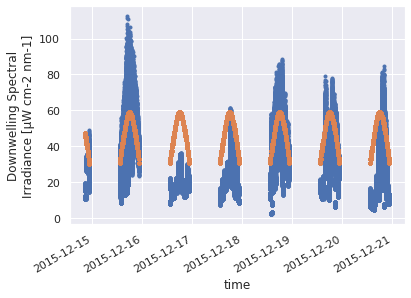

In [0]:
# Subset solar angles
ind = data_solar > 30  #Cutoff angle, this could be 0 to include all daylight hours
data_op2 = data_sub[ind]
data_op2.plot(marker='.',linestyle='')
plt.plot(data_sub.time[ind],data_solar[ind],marker='.',linestyle='');

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


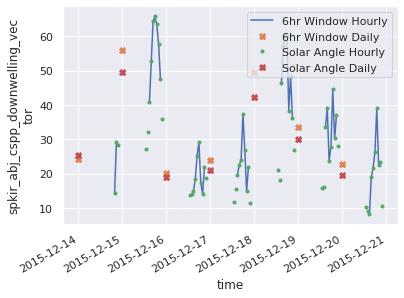

In [0]:
# Now let's plot the hourly averages for both options
data_op1.resample({'time':'H'}).mean().plot(label='6hr Window Hourly')
data_op1.resample({'time':'D'}).mean().plot(marker='X',linestyle='',label='6hr Window Daily')
data_op2.resample({'time':'H'}).mean().plot(marker='.',linestyle='',label='Solar Angle Hourly')
data_op2.resample({'time':'D'}).mean().plot(marker='X',linestyle='',label='Solar Angle Daily')
plt.legend();

### Averaging SPKIR data
Okay, so now we have a nice way to average the irradiance data during daylight hours.  Let's combine that with a for loop to iterate over all of the large data files to come up with a final daily average timeseries.

In [0]:
num = 1
spkir_data = False

for ifile in spikr_files:
  print('Downsampling file {} of {}'.format(str(num), str(len(spikr_files))))
  num=num+1
  ds = xr.open_dataset(ifile)
  ds = ds.swap_dims({'obs': 'time'})
  ds_full = ds.spkir_abj_cspp_downwelling_vector.sel(spectra=3).load()
  solar_angle = solar.get_altitude_fast(ds.geospatial_lat_min, ds.geospatial_lon_min, ds_full.time.values)
  ds_sun = xr.DataArray(solar_angle,dims=('time'),coords={'time':ds_full.time})
  ind = solar_angle>20
  ds_part = ds_full[ind]
  print(str(ds_full.sizes['time']) + ' ' + str(ds_part.sizes['time']))
  ds_fullday = ds_full.resample({'time':'D'}).mean().rename('irr_fullday')
  ds_sunday = ds_sun.resample({'time':'D'}).max().rename('sunlight')
  if ds_part.sizes['time'] > 0:
    ds_partday = ds_part.resample({'time':'D'}).mean().rename('irr_partday')
  else:
    ds_partday = ds_fullday.rename('irr_partday') * np.nan
  ds_daily = xr.merge([ds_fullday,ds_partday,ds_sunday])
  # print(ds_daily)
  if(isinstance(spkir_data,xr.Dataset)):
    # print('Append')
    spkir_data = xr.concat([spkir_data, ds_daily],dim='time')
  else:
    # print('New')
    spkir_data = ds_daily

print('Complete!')

Downsampling file 1 of 15
3055 3055
Downsampling file 2 of 15


/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4872681 2346818
Downsampling file 3 of 15
4978728 2045268
Downsampling file 4 of 15
4860048 1316117
Downsampling file 5 of 15
4980728 195601
Downsampling file 6 of 15
4979556 0
Downsampling file 7 of 15
4645578 134650
Downsampling file 8 of 15
4980050 1310399
Downsampling file 9 of 15
4980972 2025146
Downsampling file 10 of 15
2535500 1169574
Downsampling file 11 of 15
5247432 1234258
Downsampling file 12 of 15
5285746 1319001
Downsampling file 13 of 15
562138 192089
Downsampling file 14 of 15
5354522 1178944
Downsampling file 15 of 15
201371 75058
Complete!


In [0]:
spkir_data

<xarray.Dataset>
Dimensions:      (time: 1382)
Coordinates:
  * time         (time) datetime64[ns] 2015-12-22 2015-12-14 ... 2019-10-25
Data variables:
    irr_fullday  (time) float64 nan 22.93 22.31 9.489 ... 8.779 5.153 14.32
    irr_partday  (time) float64 nan 23.94 44.36 17.48 ... 19.19 26.51 44.73
    sunlight     (time) float64 59.03 47.29 58.92 58.95 ... 48.03 38.21 48.71

In [0]:
# Drop duplicate times
spkir_data = spkir_data.groupby('time').last()
spkir_data

<xarray.Dataset>
Dimensions:      (time: 1370)
Coordinates:
  * time         (time) datetime64[ns] 2015-12-14 2015-12-15 ... 2019-10-25
Data variables:
    irr_fullday  (time) float64 22.93 22.31 9.489 9.894 ... 8.779 5.153 14.32
    irr_partday  (time) float64 23.94 44.36 17.48 19.08 ... 19.19 26.51 44.73
    sunlight     (time) float64 47.29 58.92 58.95 58.98 ... 48.03 38.21 48.71

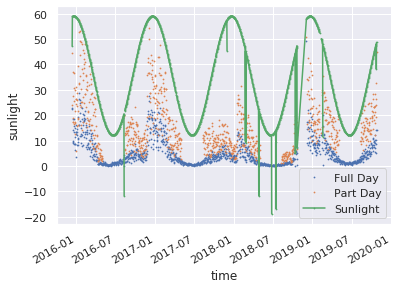

In [0]:
#Quick plot of irridiance data
spkir_data.irr_fullday.plot(label='Full Day',linestyle='',marker='.',markersize=1.5)
spkir_data.irr_partday.plot(label='Part Day',linestyle='',marker='.',markersize=1.5)
spkir_data.sunlight.plot(label='Sunlight',linestyle='-',marker='.',markersize=1.5)
plt.legend();
plt.savefig('GS01SUMO_irridiance.png')

In hindsight, it looks like it's silly to average over just the times when the sun is above a certain angle.  If we choose 30 degrees, we miss several winter months, and even 20 cuts out a chunk each year.  So, let's just use a full daily average of the irradiance, though it's an open question which channel is best to use.

## 3. Merge and export

In [0]:
# Merge the datasets
a = data_flort.rename({'fluorometric_chlorophyll_a':'Chlorophyll',
                       'temp':'Water Temp',
                       'practical_salinity':'Salinity'})
b = data_nutnr.drop(['temp','practical_salinity','nitrate_concentration']).rename({'salinity_corrected_nitrate':'Nitrate'})
c = data_nutnr2.drop(['temp','practical_salinity','nitrate_concentration']).rename({'salinity_corrected_nitrate':'Nitrate'})
d = spkir_data.rename({'irr_fullday':'Full Irradiance','irr_partday':'Peak Irradiance'})
x = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
x.head()

,Chlorophyll,Water Temp,Salinity,Nitrate,Full Irradiance,Peak Irradiance,sunlight
time,,,,,,,
2015-12-14,0.906944,6.384993,34.172389,15.511784,22.933014,23.942174,47.293905
2015-12-15,1.470704,6.444496,34.180983,16.192072,22.305523,44.356021,58.917085
2015-12-16,2.052755,6.589848,34.189894,16.499976,9.488958,17.476579,58.950767
2015-12-17,2.248522,6.626082,34.183409,16.676134,9.894163,19.075320,58.977264
2015-12-18,2.398202,6.660624,34.178840,16.654501,18.719108,36.922681,59.001829


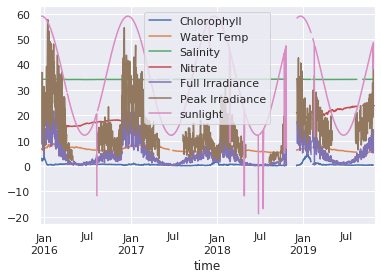

In [0]:
# Quickplot
x.plot();

In [0]:
# Export to CSV
x.to_csv('productivity.csv')

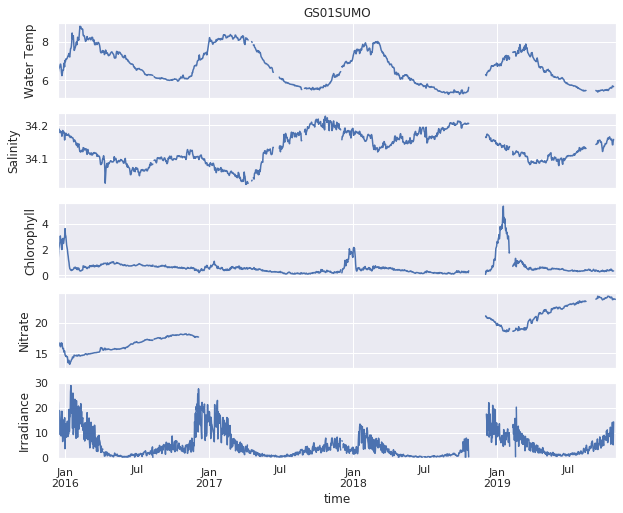

In [0]:
# Final Plot
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,sharex=True,figsize=(10,8))

x['Water Temp'].plot(ax=ax1).set_ylabel('Water Temp')
x['Salinity'].plot(ax=ax2).set_ylabel('Salinity')
x['Chlorophyll'].plot(ax=ax3).set_ylabel('Chlorophyll')
x['Nitrate'].plot(ax=ax4).set_ylabel('Nitrate')
x['Full Irradiance'].plot(ax=ax5).set_ylabel('Irradiance')
ax5.set_ylim(0,30)
ax1.set_title('GS01SUMO');
fig.savefig('GS01SUMO_productivity_final.png')

## Questions
* Do you like the full day or sun-level based irradiance?
* What about just using a measure of available sunlight?
* Do you want to include the early 2016 Nitrate data, or just the 2019 part?
* Is daily averaging sufficient for both activities?
* Do you also want to include DO or salinity?
* The daily irradiance averages doesn't seem to match the cleaner pattern seen in the full spectral dataset (where '17 and '18 are lower than '16 and '19).  Maybe we should us a different irradiance channel?  Should we smooth the data at all?